<a href="https://colab.research.google.com/github/hsyvy/ion-switching/blob/master/ion_switching_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Colab environment development

In [0]:
# mount google drive
from google.colab import drive
drive.mount('/content/gdrive')

In [0]:
from google.colab import files
files.upload()

# !pip install kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle competitions download -c liverpool-ion-switching

!unzip sample_submission.csv.zip
!unzip train.csv.zip
!unzip test.csv.zip

In [0]:
!ls

gdrive	     sample_submission.csv	test.csv.zip
kaggle.json  sample_submission.csv.zip	train.csv
sample_data  test.csv			train.csv.zip


# Ion-switching 

## imports

In [0]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import seaborn as sns
import warnings
warnings.simplefilter("ignore")
import gc

import lightgbm as lgb
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score, precision_score, recall_score, roc_auc_score
from scipy.misc import derivative
from scipy.special import softmax




## Data loading

In [0]:
train_raw = pd.read_csv("train.csv")
train_raw.head()

,time,signal,open_channels
0,0.0001,-2.7600,0
1,0.0002,-2.8557,0
2,0.0003,-2.4074,0
3,0.0004,-3.1404,0
4,0.0005,-3.1525,0


In [0]:
%%time
# clean data without feature engineering
train_clean = pd.read_csv("gdrive/My Drive/data/ion-switching/train_clean.csv")
# test = pd.read_csv("gdrive/My Drive/data/ion-switching/test_clean.csv")

CPU times: user 1.01 s, sys: 97.2 ms, total: 1.11 s
Wall time: 2.6 s


In [0]:
train.head()

,time,signal,open_channels
0,0.0001,-2.7600,0
1,0.0002,-2.8557,0
2,0.0003,-2.4074,0
3,0.0004,-3.1404,0
4,0.0005,-3.1525,0


In [0]:
train.shape

(5000000, 3)

In [0]:
test.head()

,time,signal
0,500.0001,-2.6498
1,500.0002,-2.8494
2,500.0003,-2.8601
3,500.0004,-2.4351
4,500.0005,-2.6156


In [0]:
test.shape

(2000000, 2)

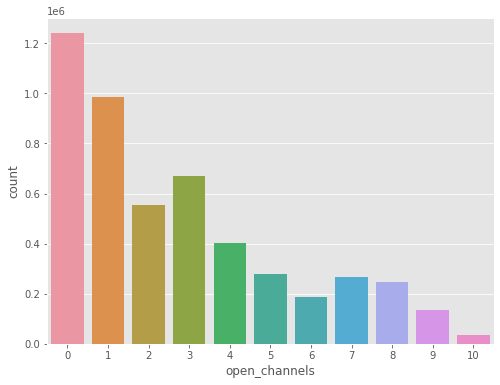

In [0]:
plt.figure(figsize=(8,6))
sns.countplot(x="open_channels", data=train)

In [3]:
%%time
# data with feature engineering v2
train = pd.read_csv("gdrive/My Drive/data/ion-switching/train_finalv2.csv")
# test = pd.read_csv("gdrive/My Drive/data/ion-switching/test_finalv2.csv")

CPU times: user 56.5 s, sys: 11.2 s, total: 1min 7s
Wall time: 1min 22s


In [4]:
train.head()

,time,signal,open_channels,last_1_feature,last_2_feature,last_3_feature,last_4_feature,last_40_feature,last_41_feature,last_42_feature,last_43_feature,last_44_feature,last_45_feature,last_46_feature,last_47_feature,last_48_feature,last_49_feature,last_50_feature,last_51_feature,last_52_feature,last_53_feature,last_54_feature,last_55_feature,last_56_feature,last_57_feature,last_58_feature,last_59_feature,last_60_feature,last_100_feature,next_1_feature,next_2_feature,next_3_feature,next_4_feature,rolling_10_mean,rolling_10_median,rolling_10_var,rolling_min_max_diff_10,rolling_25_mean,rolling_25_median,rolling_25_var,...,shifted_rolling_45_mean_5,shifted_rolling_45_median_5,shifted_rolling_45_mean_10,shifted_rolling_45_median_10,shifted_rolling_45_var_5,shifted_rolling_45_var_10,shifted_rolling_45_min_max_diff_5,shifted_rolling_45_min_max_diff_10,shifted_rolling_50_mean_5,shifted_rolling_50_median_5,shifted_rolling_50_mean_10,shifted_rolling_50_median_10,shifted_rolling_50_var_5,shifted_rolling_50_var_10,shifted_rolling_50_min_max_diff_5,shifted_rolling_50_min_max_diff_10,shifted_rolling_55_mean_5,shifted_rolling_55_median_5,shifted_rolling_55_mean_10,shifted_rolling_55_median_10,shifted_rolling_55_var_5,shifted_rolling_55_var_10,shifted_rolling_55_min_max_diff_5,shifted_rolling_55_min_max_diff_10,shifted_rolling_60_mean_5,shifted_rolling_60_median_5,shifted_rolling_60_mean_10,shifted_rolling_60_median_10,shifted_rolling_60_var_5,shifted_rolling_60_var_10,shifted_rolling_60_min_max_diff_5,shifted_rolling_60_min_max_diff_10,shifted_rolling_100_mean_5,shifted_rolling_100_median_5,shifted_rolling_100_mean_10,shifted_rolling_100_median_10,shifted_rolling_100_var_5,shifted_rolling_100_var_10,shifted_rolling_100_min_max_diff_5,shifted_rolling_100_min_max_diff_10
0,0.0001,-2.7600,0,-2.7600,-2.7600,-2.7600,-2.76,-2.76,-2.76,-2.76,-2.76,-2.76,-2.76,-2.76,-2.76,-2.76,-2.76,-2.76,-2.76,-2.76,-2.76,-2.76,-2.76,-2.76,-2.76,-2.76,-2.76,-2.76,-2.76,-2.8557,-2.4074,-3.1404,-3.1525,-2.7677,-2.729,0.0539,0.7451,-2.8215,-2.7736,0.0575,...,-2.8632,-2.8557,-2.7677,-2.729,0.0947,0.0539,0.7451,0.7451,-2.8632,-2.8557,-2.7677,-2.729,0.0947,0.0539,0.7451,0.7451,-2.8632,-2.8557,-2.7677,-2.729,0.0947,0.0539,0.7451,0.7451,-2.8632,-2.8557,-2.7677,-2.729,0.0947,0.0539,0.7451,0.7451,-2.8632,-2.8557,-2.7677,-2.729,0.0947,0.0539,0.7451,0.7451
1,0.0002,-2.8557,0,-2.7600,-2.7600,-2.7600,-2.76,-2.76,-2.76,-2.76,-2.76,-2.76,-2.76,-2.76,-2.76,-2.76,-2.76,-2.76,-2.76,-2.76,-2.76,-2.76,-2.76,-2.76,-2.76,-2.76,-2.76,-2.76,-2.76,-2.4074,-3.1404,-3.1525,-2.6418,-2.7677,-2.729,0.0539,0.7451,-2.8215,-2.7736,0.0575,...,-2.8632,-2.8557,-2.7677,-2.729,0.0947,0.0539,0.7451,0.7451,-2.8632,-2.8557,-2.7677,-2.729,0.0947,0.0539,0.7451,0.7451,-2.8632,-2.8557,-2.7677,-2.729,0.0947,0.0539,0.7451,0.7451,-2.8632,-2.8557,-2.7677,-2.729,0.0947,0.0539,0.7451,0.7451,-2.8632,-2.8557,-2.7677,-2.729,0.0947,0.0539,0.7451,0.7451
2,0.0003,-2.4074,0,-2.8557,-2.7600,-2.7600,-2.76,-2.76,-2.76,-2.76,-2.76,-2.76,-2.76,-2.76,-2.76,-2.76,-2.76,-2.76,-2.76,-2.76,-2.76,-2.76,-2.76,-2.76,-2.76,-2.76,-2.76,-2.76,-2.76,-3.1404,-3.1525,-2.6418,-2.6993,-2.7677,-2.729,0.0539,0.7451,-2.8215,-2.7736,0.0575,...,-2.8632,-2.8557,-2.7677,-2.729,0.0947,0.0539,0.7451,0.7451,-2.8632,-2.8557,-2.7677,-2.729,0.0947,0.0539,0.7451,0.7451,-2.8632,-2.8557,-2.7677,-2.729,0.0947,0.0539,0.7451,0.7451,-2.8632,-2.8557,-2.7677,-2.729,0.0947,0.0539,0.7451,0.7451,-2.8632,-2.8557,-2.7677,-2.729,0.0947,0.0539,0.7451,0.7451
3,0.0004,-3.1404,0,-2.4074,-2.8557,-2.7600,-2.76,-2.76,-2.76,-2.76,-2.76,-2.76,-2.76,-2.76,-2.76,-2.76,-2.76,-2.76,-2.76,-2.76,-2.76,-2.76,-2.76,-2.76,-2.76,-2.76,-2.76,-2.76,-2.76,-3.1525,-2.6418,-2.6993,-2.5935,-2.7677,-2.729,0.0539,0.7451,-2.8215,-2.7736,0.0575,...,-2.8632,-2.8557,-2.7677,-2.729,0.0947,0.0539,0.7451,0.7451,-2.8632,-2.8557,-2.7677,-2.729,0.0947,0.0539,0.7451,0.7451,-2.8632,-2.8557,-2.7677,-2.729,0.0947,0.0539,0.7451,0.7451,-2.8632,-2.8557,-2.7677,-2.729,0.0947,0.0539,0.7451,0.7451,-2.8632,-2.8557,-2.

### Data-preprocessing

In [0]:
# create the batch for each 50 sec data
def create_batches(df):
    batches = []
    batch_size = 500000
    for idx in range(df.shape[0] // batch_size):
        batches.append(df[idx * batch_size: (idx + 1) * batch_size])
    return batches

# train_batches = create_batches(train)
# test_batches = create_batches(test)

In [0]:
train_raw_batches = create_batches(train_raw)
train_clean_batches = create_batches(train_clean)

### Raw signal vs clean signal

In [0]:
def plot_dist(batch, data, labels):
    plt.figure()
    plt.title("Signal Distribution Model, batch "+ str(batch))
    for i, x in enumerate(data):
        x = x['signal']
        sns.distplot(x, label=labels[i], kde=True, bins=np.arange(np.min(x), np.max(x), 0.01))
    plt.xlabel("signal value")
    plt.ylabel("frequency")
    plt.legend(loc="best") 
    plt.tight_layout()
    

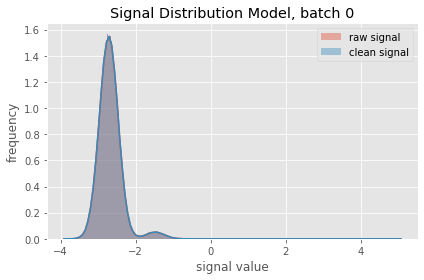

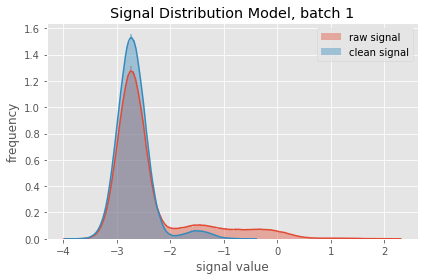

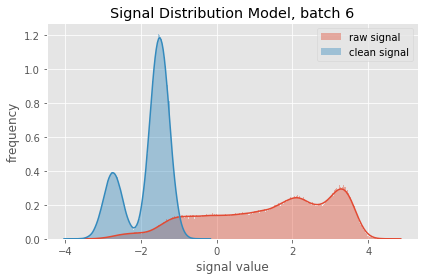

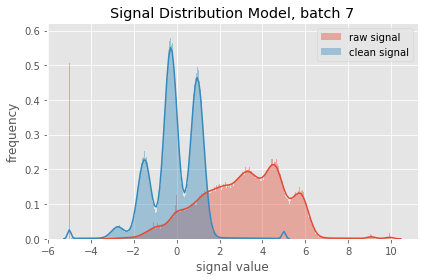

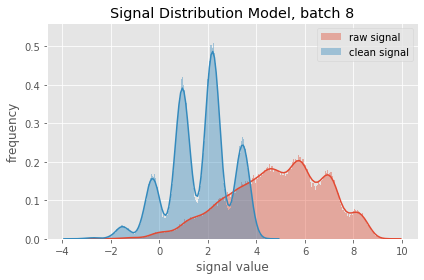

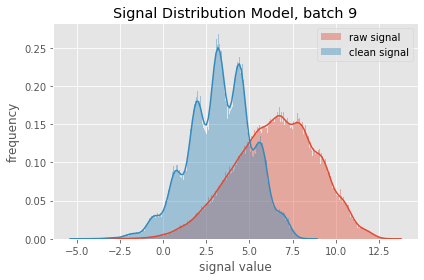

In [0]:
for i in [0, 1, 6, 7, 8, 9]:
    plot_dist(i, (train_raw_batches[i], train_clean_batches[i]), labels=['raw signal', 'clean signal'])

## Feature Engineering

### v1

In [0]:
def create_featuresv1(batches_list, num_prev_features=100, win_type=None):
    for batch in batches_list:
        # last n features
        for i in range(1, num_prev_features):
            batch['last_' + str(i)+'_feature'] = batch['signal'].shift(i) 


In [0]:
def create_featuresv1(batches_list, feature_range=list(range(1,10)), win_type=None):
    for batch in batches_list:
        # last n features
        for i in feature_range:
            batch['last_' + str(i)+'_feature'] = batch['signal'].shift(i) 

###v2

In [0]:
def create_featuresv2(batches_list, num_prev_features=51, win_type=None):
    for batch in batches_list:
        # last n features
        for i in range(1, num_prev_features):
            batch['last_' + str(i)+'_feature'] = batch['signal'].shift(i) 
        # last n rolling mean
        for i in [10, 25, 50]:
            batch['rolling_'+str(i)+ '_mean'] = batch['signal'].rolling(i, win_type=None).mean()
            batch['rolling_'+str(i)+ '_median'] = batch['signal'].rolling(i, win_type=None).median()
            batch['rolling_'+str(i)+ '_var'] = batch['signal'].rolling(i, win_type=None).var()

        # last n shifted rolling mean
        for i in [5, 10, 20, 25, 50]:
            batch['shifted_rolling_'+str(i)+ '_mean_5'] = batch['last_' + str(i)+'_feature'].rolling(5, win_type=None).mean()
            batch['shifted_rolling_'+str(i)+ '_median_5'] = batch['last_' + str(i)+'_feature'].rolling(5, win_type=None).median()
            batch['shifted_rolling_'+str(i)+ '_mean_10'] = batch['last_' + str(i)+'_feature'].rolling(10, win_type=None).mean()
            batch['shifted_rolling_'+str(i)+ '_median_10'] = batch['last_' + str(i)+'_feature'].rolling(10, win_type=None).median()
            batch['shifted_rolling_'+str(i)+ '_var_5'] = batch['last_' + str(i)+'_feature'].rolling(5, win_type=None).var()
            batch['shifted_rolling_'+str(i)+ '_var_10'] = batch['last_' + str(i)+'_feature'].rolling(10, win_type=None).var()
            

### v3

In [0]:
def create_featuresv3(batches_list, win_type=None):
    for batch in batches_list:
        # last n features
        for i in range(1, 5):
            batch['last_' + str(i)+'_feature'] = batch['signal'].shift(i)
        
        l = list(range(40,61))
        l.extend([100])
        
        for i in l:
            batch['last_' + str(i)+'_feature'] = batch['signal'].shift(i) 
        
        # next n features
        for i in range(1, 5):
            batch['next_' + str(i)+'_feature'] = batch['signal'].shift(i*-1)

        # last n rolling mean
        for i in [10, 25, 50, 60, 100]:
            batch['rolling_'+str(i)+ '_mean'] = batch['signal'].rolling(i, win_type=win_type).mean()
            batch['rolling_'+str(i)+ '_median'] = batch['signal'].rolling(i, win_type=win_type).median()
            batch['rolling_'+str(i)+ '_var'] = batch['signal'].rolling(i, win_type=win_type).var()
            batch['rolling_min_max_diff_'+str(i)] = batch['signal'].rolling(i, win_type=win_type).max()- batch['signal'].rolling(i, win_type=win_type).min()
 
        # last n shifted rolling mean
        for i in [40, 45, 50, 55, 60, 100,]:
            batch['shifted_rolling_'+str(i)+ '_mean_5'] = batch['last_' + str(i)+'_feature'].rolling(5, win_type=win_type).mean()
            batch['shifted_rolling_'+str(i)+ '_median_5'] = batch['last_' + str(i)+'_feature'].rolling(5, win_type=win_type).median()
            batch['shifted_rolling_'+str(i)+ '_mean_10'] = batch['last_' + str(i)+'_feature'].rolling(10, win_type=win_type).mean()
            batch['shifted_rolling_'+str(i)+ '_median_10'] = batch['last_' + str(i)+'_feature'].rolling(10, win_type=win_type).median()
            batch['shifted_rolling_'+str(i)+ '_var_5'] = batch['last_' + str(i)+'_feature'].rolling(5, win_type=win_type).var()
            batch['shifted_rolling_'+str(i)+ '_var_10'] = batch['last_' + str(i)+'_feature'].rolling(10, win_type=win_type).var()
            batch['shifted_rolling_'+str(i)+'_min_max_diff_5'] = batch['last_' + str(i)+'_feature'].rolling(5, win_type=win_type).max() - batch['last_' + str(i)+'_feature'].rolling(5, win_type=None).min()
            batch['shifted_rolling_'+str(i)+'_min_max_diff_10'] = batch['last_' + str(i)+'_feature'].rolling(10, win_type=win_type).max() - batch['last_' + str(i)+'_feature'].rolling(10, win_type=None).min()
            

### implementation

In [0]:
%%time
feature_range = list(range(1,15))
feature_range.extend(list(range(45, 55)))
feature_range.extend(list(range(90, 110)))
# print(feature_range)
# create_featuresv1(train_batches, feature_range)
# create_featuresv2(train_batches)
# create_featuresv3(train_batches)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109]
CPU times: user 3.84 s, sys: 12 ms, total: 3.85 s
Wall time: 3.85 s


In [0]:
%%time
create_featuresv1(train_batches, 500)


In [0]:
def fillna(batches):
    for batch in batches:
        batch.fillna(method='bfill', inplace=True)
        batch.fillna(method='ffill', inplace=True)

In [0]:
%%time
fillna(train_batches)
# fillna(test_batches)

CPU times: user 19 s, sys: 6.8 s, total: 25.8 s
Wall time: 25.9 s


In [0]:
gc.collect()

0

In [0]:
# merge batches
train = pd.concat(train_batches, ignore_index=True) 
train.head()

In [0]:
# del train, train_batches
# gc.collect()

84

# LightGBM model
- gradient boosting framework

## focal loss and f1 metrics

In [0]:
# def softmax(x):
#     x = np.exp(x - np.max(x, axis=1).reshape(x.shape[0], 1))
#     return x/x.sum(axis=1).reshape(x.shape[0], 1)

def gradian(pk, pl, flag=True, a=2., g=0.5):
    if flag:
        x = (1-pk)**g
        y = x*(1-pk)
        z = np.log(pk)
        return a*(g*pk*x*z - y)
    else:
        x = (1-pk)**(g-1)
        y = x*(1-pk)
        z = np.log(pk)
        return a*(-g*pk*pl*x*z + pl*y)

def hessian(pk, pl, flag=True, a=2., g=0.5):
    epsilon = 1e-4
    if flag:
        x = (1-pk)**g
        y = x*(1-pk)
        z = np.log(pk)
        return a*g*pk*(1-(1+g)*pk)*x*z + a*(1+2*g)*pk*y
    else:
        x = (1-pk)**(g-1)
        y = x/(1-pk)
        z = np.log(pk)
        return -a*g*pk*pl*(1-pk+g*pk*pl)*y*z + a*pl*(pk + pl + pk*pl*(2*g-1)-1)*x



def focal_loss_lgb(y_pred, dtrain, num_class=11, alpha=2, gamma=0.5):
    epsilon = 1e-6
    a,g = alpha, gamma
    y_true = dtrain.get_label()
    y_pred = np.reshape(y_pred, (y_true.shape[0], num_class), order='F')
    y_pred = softmax(y_pred, axis=1)
    y_pred = np.clip(y_pred, epsilon, 1-epsilon)

    assert y_pred.shape[0] == y_true.shape[0]
    # print(y_pred[4, 2])



    grad = np.zeros(shape=(y_pred.shape[0], num_class))
    hess = np.zeros(shape=(y_pred.shape[0], num_class))

    for i in range(y_pred.shape[0]):
        label = y_true.iloc[i]
        # print('i: ', i)
        for j in range(num_class):
            if(j == label):
                # print('j:',j)
                grad[i, j] = gradian(y_pred[i, label], y_pred[i, j], True, a, g) 
                hess[i, j] = hessian(y_pred[i, label], y_pred[i, j], True, a, g)
            else:
                # print("j: ", j)
                grad[i, j] = gradian(y_pred[i, label], y_pred[i, j], False, a, g) 
                hess[i, j] = hessian(y_pred[i, label], y_pred[i, j], False, a ,g)
    # print("grad\n", grad)
    # print('hess\n')
    # print(hess)

    return grad.reshape(-1, order='F'), hess.reshape(-1, order='F')

In [0]:
def focal_loss_lgb(y_pred, dtrain, num_class=11, alpha=2, gamma=0.5):
    epsilon = 1e-6
    a,g = alpha, gamma
    y_true = dtrain.get_label()
    print(type(y_true))
    print('y_true shape: ', y_true.shape)
    # print(y_true[:10])
    print(type(y_pred))
    print(y_pred.shape)
    # print(y_pred[:20])
    y_pred = np.reshape(y_pred, (len(y_true), num_class), order='F')
    y_pred = softmax(y_pred, axis=1)
    assert y_pred.shape[0] == y_true.shape[0]

    grad = np.zeros(shape=(y_pred.shape[0], num_class))
    hess = np.zeros(shape=(y_pred.shape[0], num_class))


    return grad.reshape(-1, order='F'), hess.reshape(-1, order='F')

In [0]:
# additional metric for evaluation in lightGBM classifier
def lgb_f1_score_class(y_pred, data):
    y_true = data.get_label()
    y_pred = np.reshape(y_pred,(len(y_true), 11), order='F')
    y_pred = np.argmax(y_pred, axis=1)
    return 'f1', f1_score(y_true, y_pred, average='macro'), True

In [0]:
a = [0, 1, 1.2, 3, 3.2]
np.rint(np.clip(a, 0, 3)).astype('int')

array([0, 1, 1, 3, 3])

In [0]:
# additional metric for evaluation in lightGBM Regression
def lgb_f1_score_reg(y_pred, data):
    y_true = data.get_label()
    # y_pred = np.reshape(y_pred,(len(y_true), 11), order='F')
    y_pred = np.rint(np.clip(y_pred, 0, 10)).astype('int')
    return 'f1', f1_score(y_true, y_pred, average='macro'), True

## data preparation for lgb

In [0]:
# lightGBM dataset
def lgb_dataset(df, target_col=None, cols_to_drop=None, keep=False):
    y = df[target_col]    
    lgb_data = lgb.Dataset(df.drop(columns=cols_to_drop), y)
    if not keep:
        del df
        gc.collect()
    return lgb_data


In [0]:
# train and val data split
train_id = list()
val_id = list()
for i in range(0, 5000000, 500000):
    train_id.extend(list(range(i, i+450000)))
    val_id.extend(list(range(i+450000, i+500000)))

In [9]:
%%time
target_col = "open_channels"
cols_to_drop=["time", "open_channels"]
lgb_train = lgb_dataset(train.loc[train_id], target_col, cols_to_drop, keep=True)
lgb_val = lgb_dataset(train.loc[val_id], target_col, cols_to_drop, keep=True)

CPU times: user 4.01 s, sys: 2.78 s, total: 6.78 s
Wall time: 6.81 s


## model train

In [0]:
# lightgbm classifier boosting parameters
lgb_params = {"boosting_type": "gbdt",
              "num_leaves": 2**4-1,
              "max_depth": -1,
              "learning_rate": 0.05,
              "n_estimators": 20,
              "objective": "multiclass",  
              "num_class": 11,
            #   "metrics": ["multi_logloss"],
            #   "reg_alpha": 0.001,
            #   "reg_lambda": 0.001,
              "n_jobs": -1,
              "random_state": 7,
              }

In [0]:
# lightgbm regressor boosting parameters
lgb_params = {"boosting_type": "gbdt",
              "num_leaves": 2**8-1,
              "max_depth": -1,
              "learning_rate": 0.08,
              "n_estimators": 256,
              "objective": "regression",  
              "reg_alpha": 0.001,
              "reg_lambda": 0.001,
              "n_jobs": -1,
              "random_state": 7,
              }

In [12]:
%%time
lgb_model = lgb.train(params = lgb_params, 
                train_set = lgb_train,
                valid_sets = lgb_val,      
                num_boost_round = 200, 
                feval = lgb_f1_score_reg,       
                verbose_eval = 10,
                early_stopping_rounds = 100,)

Training until validation scores don't improve for 100 rounds.
[10]	valid_0's l2: 1.37556	valid_0's f1: 0.127857
[20]	valid_0's l2: 0.294046	valid_0's f1: 0.405468
[30]	valid_0's l2: 0.0872997	valid_0's f1: 0.759791
[40]	valid_0's l2: 0.0469227	valid_0's f1: 0.915453
[50]	valid_0's l2: 0.0384729	valid_0's f1: 0.9218
[60]	valid_0's l2: 0.0363519	valid_0's f1: 0.924262
[70]	valid_0's l2: 0.0355463	valid_0's f1: 0.924719
[80]	valid_0's l2: 0.0351359	valid_0's f1: 0.925033
[90]	valid_0's l2: 0.0348296	valid_0's f1: 0.925237
[100]	valid_0's l2: 0.0345416	valid_0's f1: 0.925501
[110]	valid_0's l2: 0.0343571	valid_0's f1: 0.925712
[120]	valid_0's l2: 0.0342069	valid_0's f1: 0.925779
[130]	valid_0's l2: 0.0341168	valid_0's f1: 0.925903
[140]	valid_0's l2: 0.034019	valid_0's f1: 0.925987
[150]	valid_0's l2: 0.0339375	valid_0's f1: 0.926091
[160]	valid_0's l2: 0.0338479	valid_0's f1: 0.926171
[170]	valid_0's l2: 0.0337711	valid_0's f1: 0.926203
[180]	valid_0's l2: 0.0337047	valid_0's f1: 0.92627

In [0]:
%%time
lgb_model = lgb.train(params = lgb_params, 
                train_set = lgb_train,
                valid_sets = lgb_val,      
                num_boost_round = 100, 
                fobj = focal_loss_lgb,
                feval = lgb_f1_score_class,       
                verbose_eval = 1,
                early_stopping_rounds = 10,)

## LightGBM model analysis

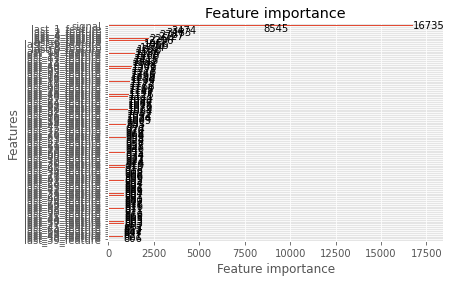

In [0]:
lgb.plot_importance(lgb_model, height=0.1,)

In [0]:
def plot_cm(y_true, y_pred, figsize=(20,15)):
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=np.unique(y_true), columns=np.unique(y_true))
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    # sns.set(font_scale=1.4)
    
    sns.heatmap(cm, cmap= "YlGnBu", annot=annot, fmt='', ax=ax)
    


In [0]:
%%time
# for classifier model
y_pred1 = lgb_model.predict(train.drop(columns=cols_to_drop).loc[val_id])
y_pred1 = np.argmax(y_pred1, axis=1)
y_true = train.loc[val_id, 'open_channels']

CPU times: user 1min 17s, sys: 166 ms, total: 1min 17s
Wall time: 25.4 s


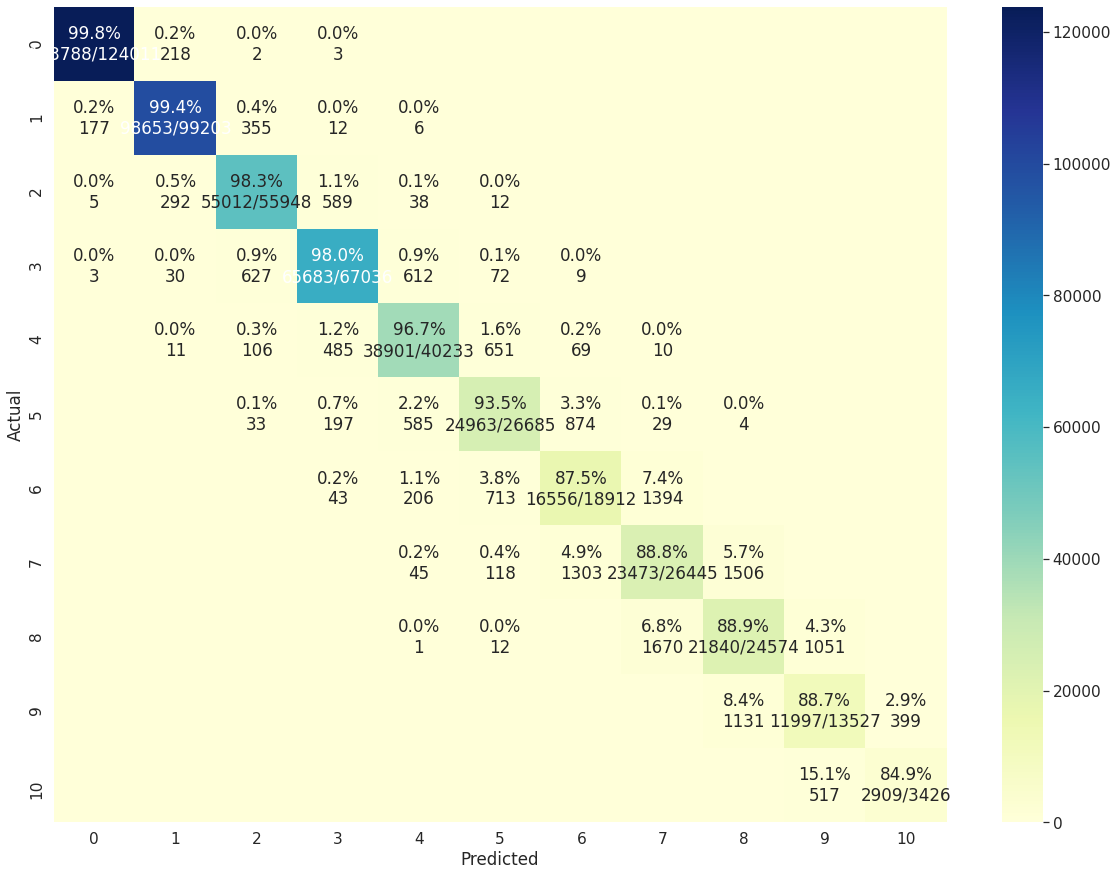

In [0]:
# %%time
plot_cm(y_true, y_pred1)

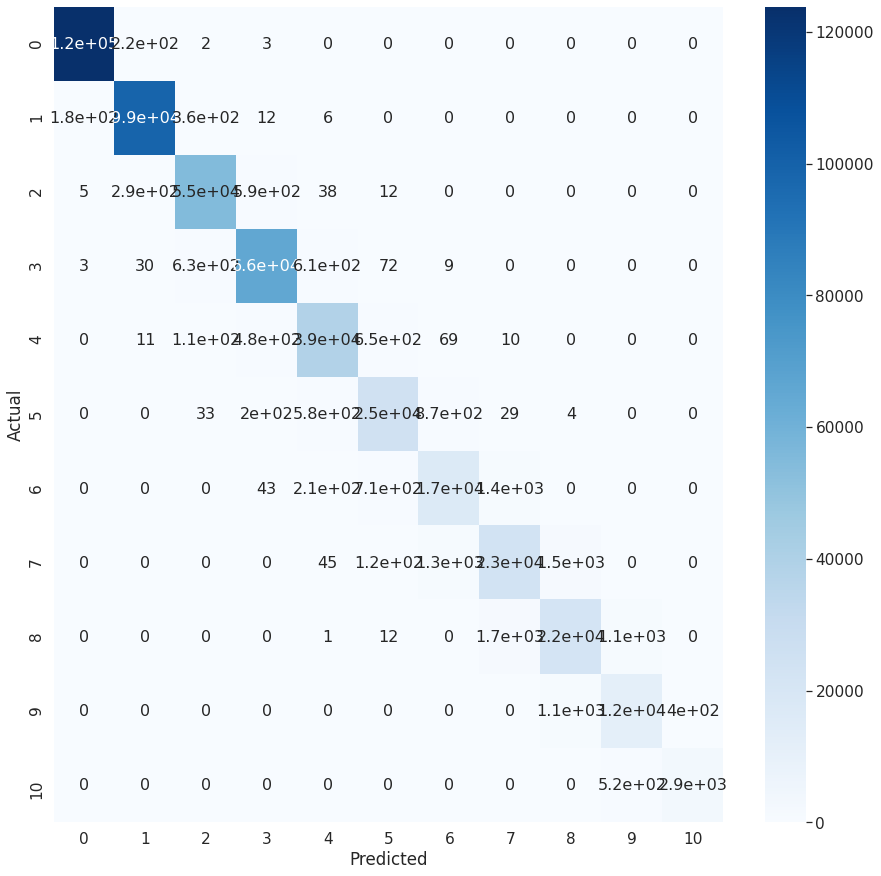

In [0]:
data = confusion_matrix(y_true, y_pred1)
df_cm = pd.DataFrame(data, columns=np.unique(y_true), index = np.unique(y_true))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (15,15))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})# font size

In [0]:
%%time
y_pred = lgb_model.predict(train.drop(columns=cols_to_drop).loc[val_id])
y_pred = np.argmax(y_pred, axis=1)
y_true = train.loc[val_id, 'open_channels']

CPU times: user 625 ms, sys: 307 ms, total: 932 ms
Wall time: 654 ms


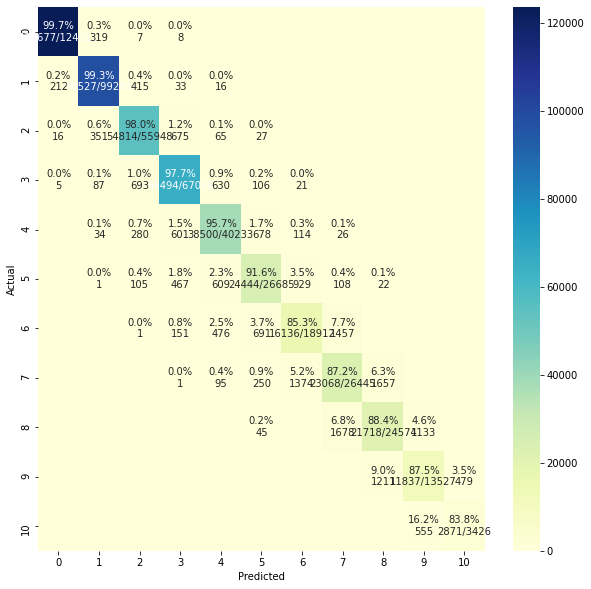

In [0]:
%%time
plot_cm(y_true, y_pred)

In [13]:
%%time
# for regressor model
y_pred = lgb_model.predict(train.drop(columns=cols_to_drop).loc[val_id])
y_pred = np.rint(np.clip(y_pred, 0, 10)).astype('int')
y_true = train.loc[val_id, 'open_channels']
cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
print(cm)


[[123730    277      4      0      0      0      0      0      0      0
       0]
 [   187  98553    460      3      0      0      0      0      0      0
       0]
 [     0    287  54851    800     10      0      0      0      0      0
       0]
 [     0     13    690  65301   1004     28      0      0      0      0
       0]
 [     0      4     40    692  38320   1150     27      0      0      0
       0]
 [     0      0      7    147    899  24458   1146     27      1      0
       0]
 [     0      0      0     12    170   1159  16157   1414      0      0
       0]
 [     0      0      0      0     16    121   1625  23179   1504      0
       0]
 [     0      0      0      0      1      4     12   1725  21851    981
       0]
 [     0      0      0      0      0      0      0      0   1177  11864
     486]
 [     0      0      0      0      0      0      0      0      0    383
    3043]]
CPU times: user 16.4 s, sys: 40.9 ms, total: 16.5 s
Wall time: 7.12 s


In [0]:
y_pred_prob = lgb_model.predict(train.drop(columns=cols_to_drop).loc[val_id])


In [34]:
print("accuracy: ", accuracy_score(y_true, y_pred))
print("precision: ", precision_score(y_true, y_pred, average='macro'))
print("recall: ", recall_score(y_true, y_pred, average='macro'))
print("macro f1 score: ", f1_score(y_true, y_pred, average='macro'))


accuracy:  0.962614
precision:  0.9258736696330035
recall:  0.9272703289696413
macro f1 score:  0.9265417796699965


In [15]:
for i in range(10):
    print(cm[i])

[123730    277      4      0      0      0      0      0      0      0
      0]
[  187 98553   460     3     0     0     0     0     0     0     0]
[    0   287 54851   800    10     0     0     0     0     0     0]
[    0    13   690 65301  1004    28     0     0     0     0     0]
[    0     4    40   692 38320  1150    27     0     0     0     0]
[    0     0     7   147   899 24458  1146    27     1     0     0]
[    0     0     0    12   170  1159 16157  1414     0     0     0]
[    0     0     0     0    16   121  1625 23179  1504     0     0]
[    0     0     0     0     1     4    12  1725 21851   981     0]
[    0     0     0     0     0     0     0     0  1177 11864   486]


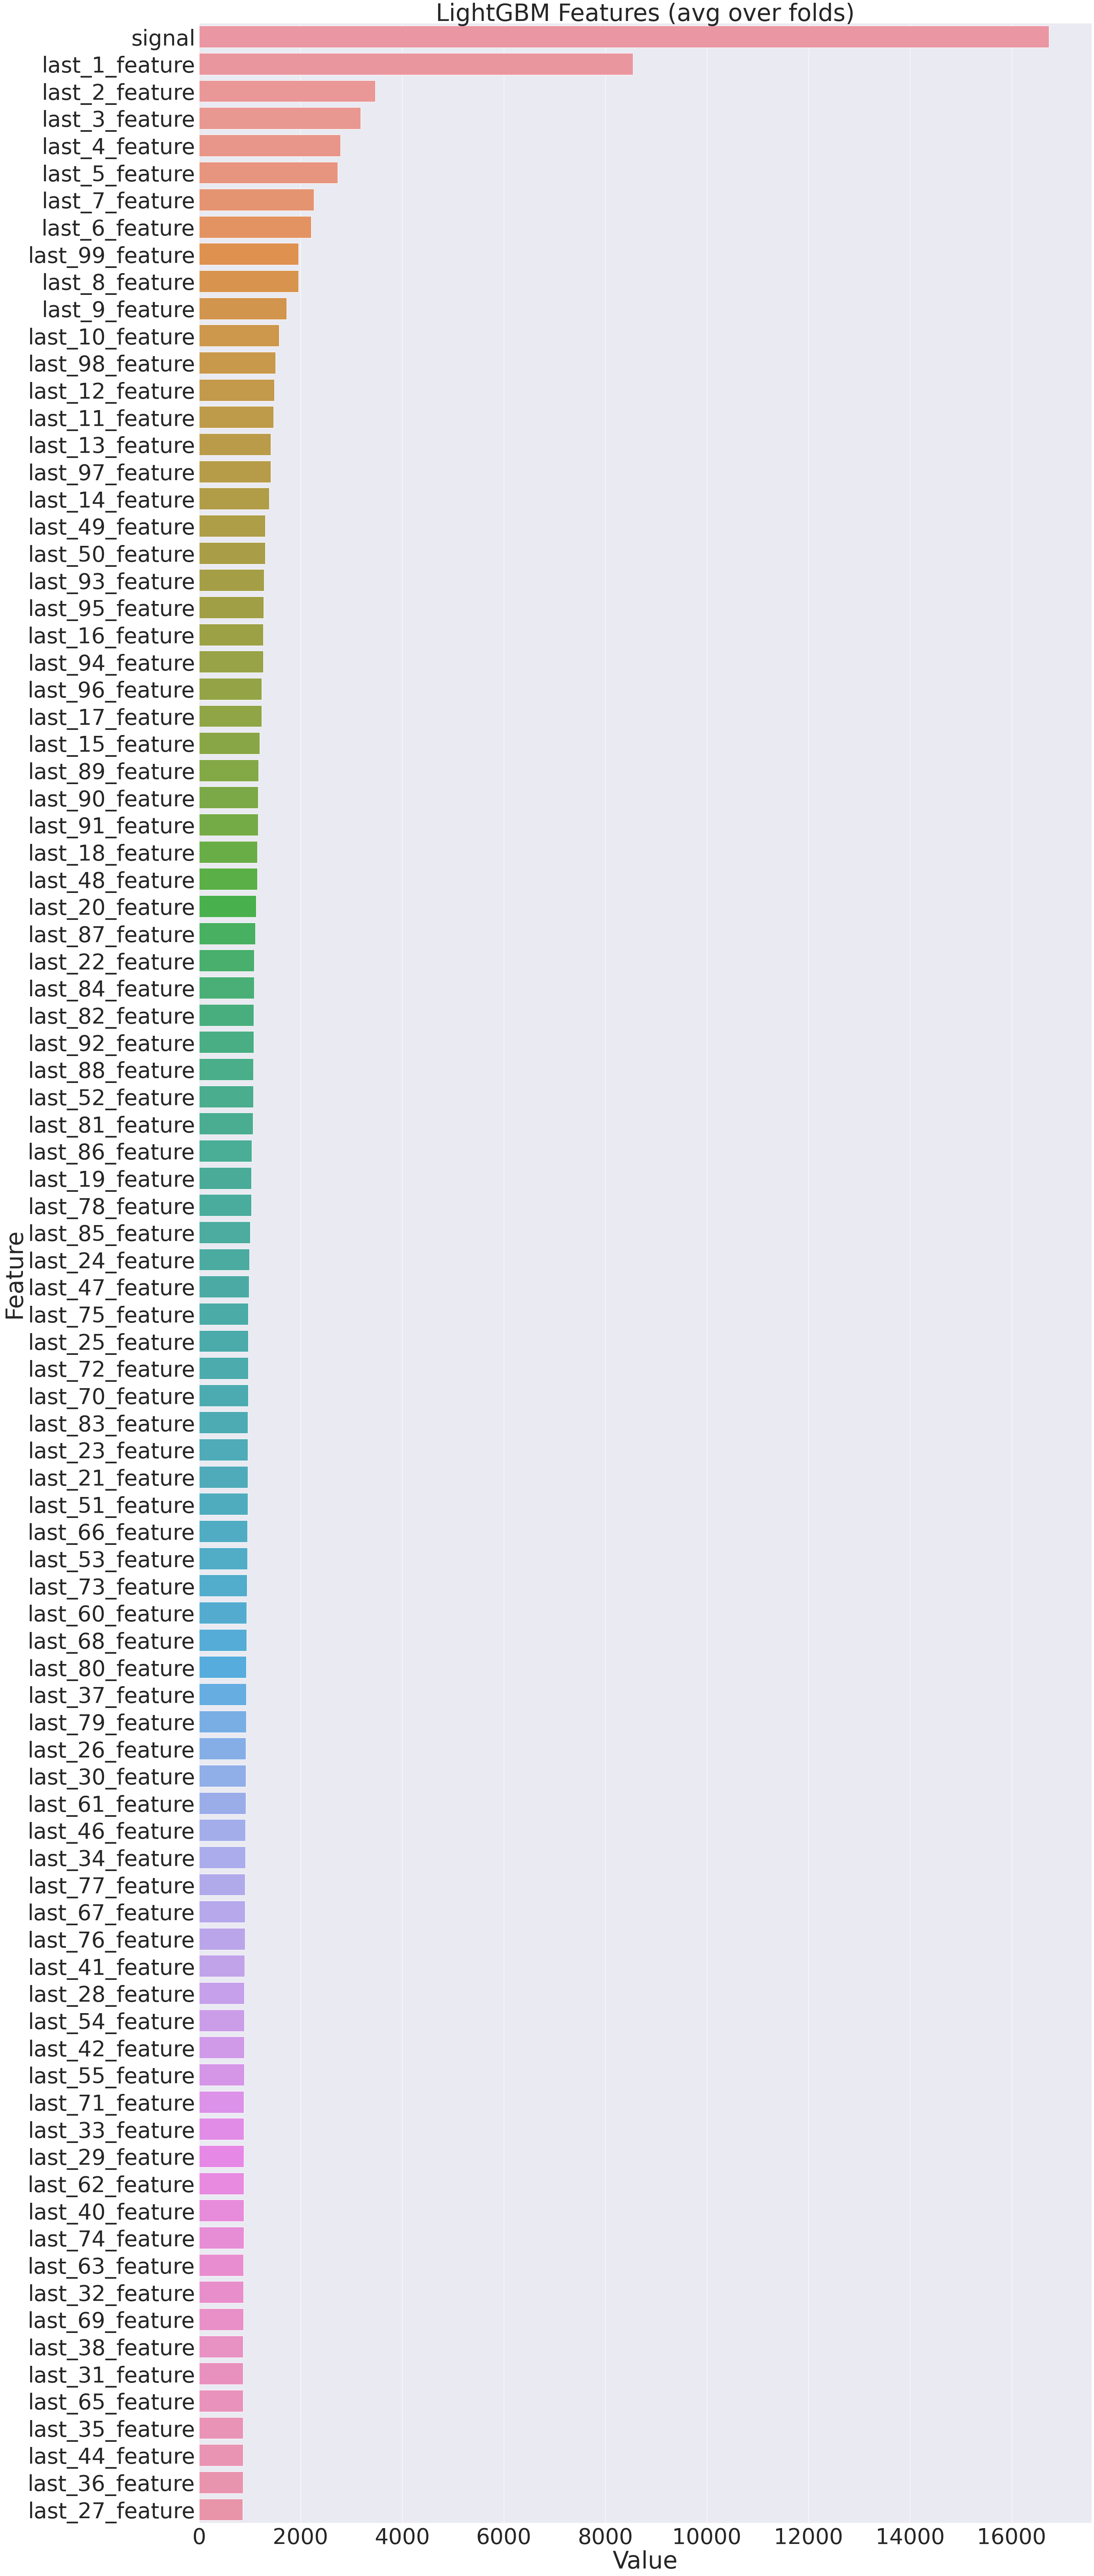

In [0]:
cols = list(train.drop(columns=cols_to_drop).columns)
def plotImp(model, cols , num = 20):
    feature_imp = pd.DataFrame({'Value':model.feature_importance(),'Feature':cols})
    plt.figure(figsize=(40, 92))
    sns.set(font_scale = 5)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", 
                                                        ascending=False)[0:num])
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('gdrive/My Drive/data/ion-switching/lgbm_importancesv0.png')
    plt.show()

plotImp(lgb_model, cols, 92)

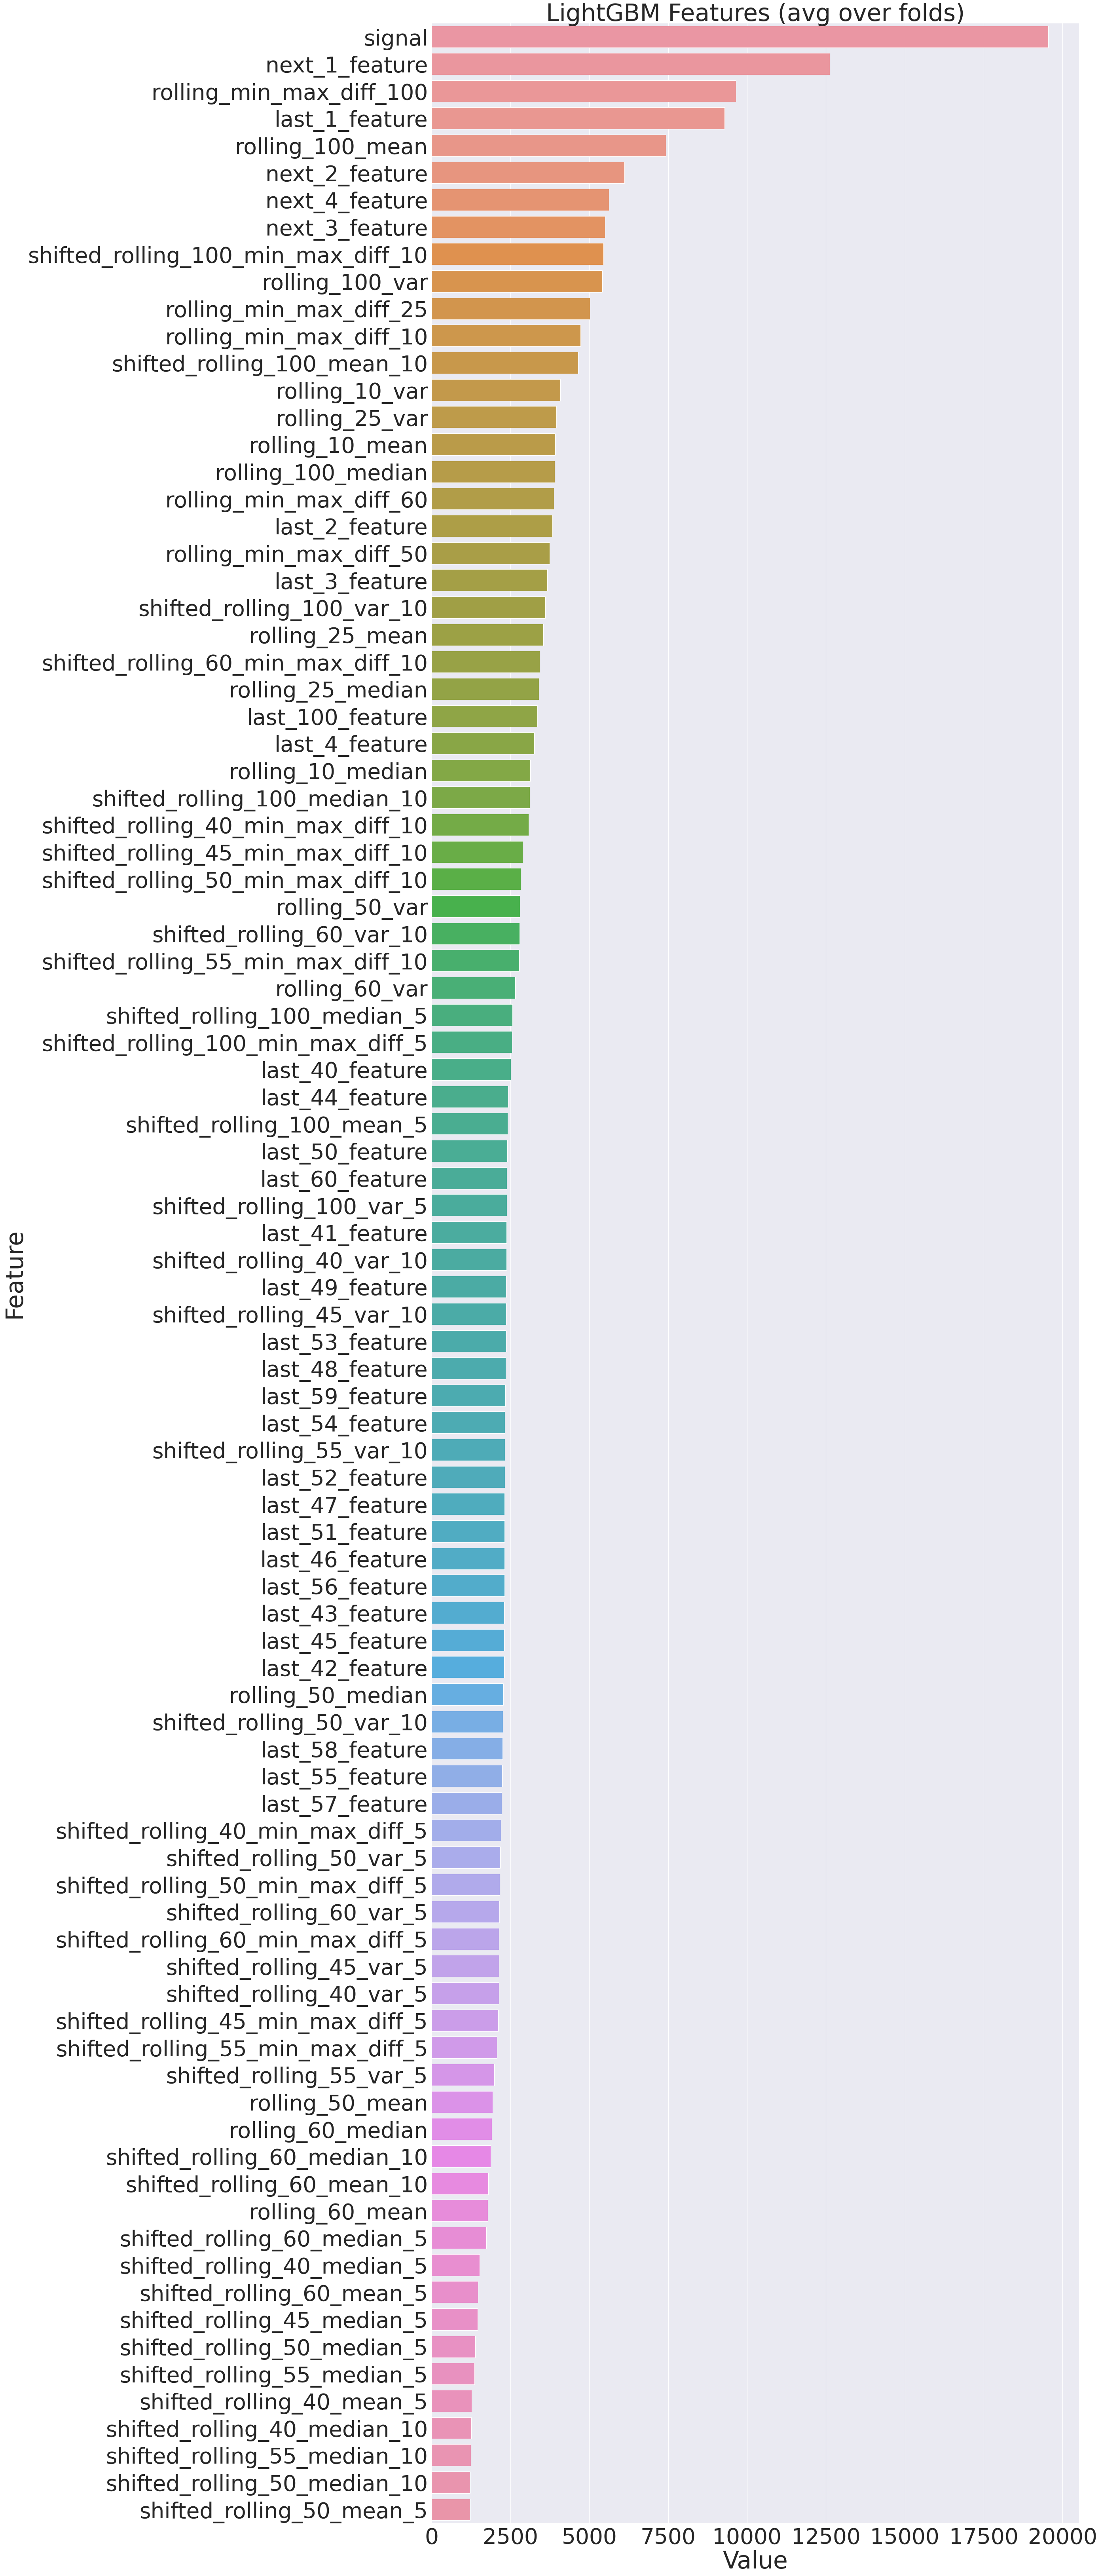

# Prediction

In [0]:
cols = list(test.columns)
cols = cols[1:]

In [0]:
test = pd.read_csv("gdrive/My Drive/data/ion-switching/test_finalv2.csv")


In [0]:
%%time
cols = list(test.columns)
cols = cols[1:]
preds = modelLgb.predict(test.loc[:, cols])
res = np.argmax(preds, axis=1)

CPU times: user 3min 36s, sys: 1.22 s, total: 3min 37s
Wall time: 58.6 s


In [0]:
len(res)

1499999

In [0]:
t = pd.read_csv("test.csv")

In [0]:
t['open_channels'] = res

In [0]:
t[['time','open_channels']].to_csv('gdrive/My Drive/data/ion-switching/subv3.csv', index=False, float_format='%.4f')

In [0]:
sub.open_channels = res

# logs

#### model: lightgbm with 100 estimators and 2**7-1 leaves
features version 0 with 100 shifted features
Training until validation scores don't improve for 150 rounds.

[10]	valid_0's multi_logloss: 1.0317	valid_0's f1: 0.914318

[20]	valid_0's multi_logloss: 0.638123	valid_0's f1: 0.922837

[30]	valid_0's multi_logloss: 0.426421	valid_0's f1: 0.923645

[40]	valid_0's multi_logloss: 0.303382	valid_0's f1: 0.924218

[50]	valid_0's multi_logloss: 0.229474	valid_0's f1: 0.924696

[60]	valid_0's multi_logloss: 0.184185	valid_0's f1: 0.925135

[70]	valid_0's multi_logloss: 0.155879	valid_0's f1: 0.92539

[80]	valid_0's multi_logloss: 0.137785	valid_0's f1: 0.925622

[90]	valid_0's multi_logloss: 0.126008	valid_0's f1: 0.925916

[100]	valid_0's multi_logloss: 0.118199	valid_0's f1: 0.926071

Did not meet early stopping. Best iteration is:

[100]	valid_0's multi_logloss: 0.118199	valid_0's f1: 0.926071
CPU times: user 1h 17min 19s, sys: 10.1 s, total: 1h 17min 29s
Wall time: 20min 2s

# testing of codes

In [0]:
%%time
modelLgb = lgb.cv(params = lgb_params, 
                train_set = lgb_train,
                num_boost_round= 500,
                folds = None,
                nfold = 5,
                stratified = True,
                shuffle = True,
                # feval = lgb_f1_score,      
                verbose_eval=5,
                early_stopping_rounds=250, 
                seed = 7)



[5]	cv_agg's multi_logloss: 0.0295215 + 0.000221854
[10]	cv_agg's multi_logloss: 0.0191247 + 0.000210977
[15]	cv_agg's multi_logloss: 0.0127889 + 0.000238789
[20]	cv_agg's multi_logloss: 0.00874251 + 0.000271495
[25]	cv_agg's multi_logloss: 0.006114 + 0.000291415
[30]	cv_agg's multi_logloss: 0.00437385 + 0.000318884
[35]	cv_agg's multi_logloss: 0.00322424 + 0.000346242
[40]	cv_agg's multi_logloss: 0.00245795 + 0.000358087
[45]	cv_agg's multi_logloss: 0.0019601 + 0.000367688
[50]	cv_agg's multi_logloss: 0.00163193 + 0.000382814
[55]	cv_agg's multi_logloss: 0.00141722 + 0.000404556
[60]	cv_agg's multi_logloss: 0.00128982 + 0.000421819
[65]	cv_agg's multi_logloss: 0.0012033 + 0.000442764
[70]	cv_agg's multi_logloss: 0.00115439 + 0.000469251
[75]	cv_agg's multi_logloss: 0.00112262 + 0.000482437
[80]	cv_agg's multi_logloss: 0.0011157 + 0.000505918
[85]	cv_agg's multi_logloss: 0.00111455 + 0.000523774
[90]	cv_agg's multi_logloss: 0.00111956 + 0.000538853
[95]	cv_agg's multi_logloss: 0.001136

In [0]:
# def softmax(x):
#     x = np.exp(x - np.max(x, axis=1).reshape(x.shape[0], 1))
#     return x/x.sum(axis=1).reshape(x.shape[0], 1)

def focal_loss_lgb(y_pred, dtrain, alpha=1, gamma=0):
    a,g = alpha, gamma
    y_true = dtrain.get_label()
    # print(y_pred[4956886:4958000])
    # print(y_true.shape)
    print(y_pred[:12])
    print(y_pred[:3].sum())
    y_pred = np.reshape(y_pred,(len(y_true), 3), order='F')
    print(y_pred[:2])
    print(y_pred[:1].sum())
    # y_pred = np.reshape(y_pred, (len(y_true), 11), order='F')
    # print(y_pred.shape)

    #   def fl(y_pred, y_true):
    #   	# p = 1/(1+np.exp(-x))
    #     p = softmax(y_pred, axis=1)
    #     y_true = np.array(y_true).reshape(-1, 1)
    #     pt = np.take_along_axis(p, y_true, axis=-1)
    #   	# return -( a*t + (1-a)*(1-t) ) * (( 1 - ( t*p + (1-t)*(1-p)) )**g) * ( t*np.log(p)+(1-t)*np.log(1-p) )
    #     return (-a*(1-pt)**g*np.log(pt)).reshape(-1)
    

    #   partial_fl = lambda y_pred: fl(y_pred, y_true)
    #   grad = derivative(partial_fl, y_pred, n=1, dx=1e-6)
    p = softmax(y_pred, axis=1)
    print(p[:2])
    print(p[:1].sum())
    # y_true = np.array(y_true).reshape(-1, 1)
    # pt = np.take_along_axis(p, y_true, axis=1)
    # pt += 1e-6
    # # print(pt)

    # x = (1-pt)**g
    # y = x/(1-pt)
    # z = y/(1-pt)
    # w = np.log(pt)
    # grad = a*(g*y*w - x/p)
    # grad = grad.reshape(-1)
    # hess = a*(-g*(g-1)*z*w + 2*g*y/p + x/(p**2))
    # hess = hess.reshape(-1)
    # print(hess)
    # print(grad)
    q = 2*p
    #   hess = derivative(partial_fl, y_pred, n=2, dx=1e-6)
    print(p.shape)
    return np.random.rand(y_pred.shape[0], y_pred.shape[1]).reshape(-1), np.random.rand(y_pred.shape[0], y_pred.shape[1]).reshape(-1)

In [0]:
def focal_loss_lgb_eval_error(y_pred, dtrain, alpha, gamma):
  a,g = alpha, gamma
  y_true = dtrain.label
  p = 1/(1+np.exp(-y_pred))
  loss = -( a*y_true + (1-a)*(1-y_true) ) * (( 1 - ( y_true*p + (1-y_true)*(1-p)) )**g) * ( y_true*np.log(p)+(1-y_true)*np.log(1-p) )
  # (eval_name, eval_result, is_higher_better)
  return 'focal_loss', np.mean(loss), False

In [0]:
# additional metric for evaluation in lightGBM
def lgb_f1_score(y_pred, data):
    y_true = data.get_label()
    # print(y_pred[:22])
    # print(y_pred[:11].sum())
    y_pred = np.reshape(y_pred,(len(y_true), 11), order='F')
    # print(y_pred[:2])
    # print(y_pred[:1].sum())
    y_pred = np.argmax(y_pred, axis=1)
    return 'f1', f1_score(y_true, y_pred, average='macro'), True

In [0]:
x = np.random.rand(3,5)
y = [1, 2, 4]
print(x)
x

[[0.52234671 0.42601982 0.69586967 0.20430726 0.77752276]
 [0.31115478 0.81438284 0.33290096 0.06239958 0.16058122]
 [0.84310825 0.00186917 0.36084899 0.97751551 0.872701  ]]


array([[0.52234671, 0.42601982, 0.69586967, 0.20430726, 0.77752276],
       [0.31115478, 0.81438284, 0.33290096, 0.06239958, 0.16058122],
       [0.84310825, 0.00186917, 0.36084899, 0.97751551, 0.872701  ]])

In [0]:
y_pred = np.array([1, 2, 3, 4, 5, 6, 7, 8 , 9, 10, 11, 13])
np.reshape(y_pred, (4, 3), order='F')

array([[ 1,  5,  9],
       [ 2,  6, 10],
       [ 3,  7, 11],
       [ 4,  8, 13]])

In [0]:
def fl(y_pred, y_true):
  	# p = 1/(1+np.exp(-x))
    a = 2
    g =0.5
    p = softmax(y_pred, axis=1)
    y_true = np.array(y_true).reshape(-1, 1)
    pt = np.take_along_axis(p, y_true, axis=-1)
  	# return -( a*t + (1-a)*(1-t) ) * (( 1 - ( t*p + (1-t)*(1-p)) )**g) * ( t*np.log(p)+(1-t)*np.log(1-p) )
    return (-a*(1-pt)**g*np.log(pt)).reshape(-1)

In [0]:
x = np.random.rand(3, 5)
print(x, '\n',  x[1, 3])


[[0.76855234 0.32541911 0.29103921 0.95893138 0.30944735]
 [0.2518152  0.83733783 0.21238705 0.75217013 0.39785218]
 [0.29448002 0.87449696 0.64492076 0.04184467 0.07536962]] 
 0.7521701309699464


In [0]:
fl(x, y).reshape(-1)

array([3.13551418, 2.96404414, 2.45346831])